In [2]:
import os
import pandas as pd
import shutil

In [3]:
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'

%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import cv2
import gc
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.model_selection import StratifiedKFold, train_test_split
from keras_preprocessing.image import load_img, img_to_array, array_to_img ,ImageDataGenerator
from tensorflow.keras.models import Sequential
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D , GlobalAveragePooling2D

from keras.optimizers import Adam , RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
import tensorflow as tf

from keras import callbacks
from keras.callbacks import ModelCheckpoint, LearningRateScheduler , EarlyStopping ,TensorBoard
from keras import optimizers
from keras.models import load_model

from keras.applications.xception import Xception
#from keras.applications import VGG16
from keras.applications.vgg16 import VGG16, preprocess_input

2024-06-18 02:40:04.323985: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-18 02:40:05.733728: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [19]:
from tensorflow.keras.regularizers import l2, l1
from tensorflow.keras.models import Sequential

In [42]:
import torch

torch.version.cuda

'12.1'

In [51]:
# Load the CSV file
train_csv_path = 'sam/Meat Freshness.v1-new-dataset.multiclass/train/_classes.csv'  # Update the path as needed
valid_csv_path = 'sam/Meat Freshness.v1-new-dataset.multiclass/valid/_classes.csv'  # Update the path as needed

train_data = pd.read_csv(train_csv_path)
valid_data = pd.read_csv(valid_csv_path)

# Define base directories
train_dir = 'sam/Meat Freshness.v1-new-dataset.multiclass/train/'
valid_dir = 'sam/Meat Freshness.v1-new-dataset.multiclass/valid/'

# Print the column names to check for any discrepancies
print("Train Data Columns:", train_data.columns)
print("Valid Data Columns:", valid_data.columns)

train_data['filename'] = train_data['filename'].apply(lambda x: os.path.join(train_dir, x))
valid_data['filename'] = valid_data['filename'].apply(lambda x: os.path.join(valid_dir, x))
train_data.columns = train_data.columns.str.strip()
valid_data.columns = valid_data.columns.str.strip()

Train Data Columns: Index(['filename', ' Fresh', ' Half-Fresh', ' Spoiled'], dtype='object')
Valid Data Columns: Index(['filename', ' Fresh', ' Half-Fresh', ' Spoiled'], dtype='object')


In [44]:
import warnings

warnings.filterwarnings('ignore')

# Check the current directory
print("Current directory contents:")
print(os.listdir('.'))

# Attempt to list the contents of the input directory
input_path = "../input"
if os.path.exists(input_path):
    print(f"Contents of '{input_path}' directory:")
    print(os.listdir(input_path))
else:
    print(f"Directory '{input_path}' does not exist. Please check the path.")

Current directory contents:
['.classiq-credentials', 'quantumv4-Copy2.ipynb', '.ssh', '.keras', '.jupyter', 'credit_card_fraud.ipynb', '.config', '.local', '.conda', '.bashrc', 'credit_card_fraud.synthesis_options.json', 'quantum4.ipynb', '.qiskit', '.profile', 'AML_Project_David.ipynb', 'sam', '.docker', 'AML_Project_yilinwen.ipynb', 'quantumv4-Copy1.ipynb', 'data', 'cc.synthesis_options.json', 'QSVM.synthesis_options.json', 'Kathy', 'Final Project.ipynb', '.cache', 'quantumv4.ipynb', '.nv', 'cc.qmod', 'quantum3.ipynb', '.ipython', '.kaggle', '.bash_history', '.bash_logout', 'credit_card_fraud.qmod', '.wget-hsts', 'QSVM.qmod', '.ipynb_checkpoints']
Directory '../input' does not exist. Please check the path.


In [116]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

valid_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_data,
    x_col='filename',
    y_col=['Fresh', 'Half-Fresh', 'Spoiled'],
    target_size=(224, 224),
    batch_size=20,
    class_mode='raw',
    shuffle=False
)

valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=valid_data,
    x_col='filename',
    y_col=['Fresh', 'Half-Fresh', 'Spoiled'],
    target_size=(224, 224),
    batch_size=20,
    class_mode='raw',
    shuffle=False
)

Found 1815 validated image filenames.
Found 451 validated image filenames.


# Train VGG Model

In [122]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

# Load the VGG16 model with pre-trained weights
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers on top of the VGG base
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)

# Define the full model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the VGG base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [123]:
# Train the model 15:36 -- 15:59
history = model.fit(
    train_generator,
    steps_per_epoch=10,  # Very few steps per epoch
    epochs=20,  # Very few epochs
    validation_data=valid_generator,
    validation_steps=10
)


Epoch 1/20
10/10 [==============================] - 4s 286ms/step - loss: 2.7976 - accuracy: 0.3600 - val_loss: 1.9493 - val_accuracy: 0.2850
Epoch 2/20
10/10 [==============================] - 3s 275ms/step - loss: 1.1498 - accuracy: 0.4974 - val_loss: 0.7101 - val_accuracy: 0.6400
Epoch 3/20
10/10 [==============================] - 3s 286ms/step - loss: 0.6505 - accuracy: 0.7400 - val_loss: 0.3921 - val_accuracy: 0.8400
Epoch 4/20
10/10 [==============================] - 3s 288ms/step - loss: 0.4236 - accuracy: 0.8400 - val_loss: 0.4051 - val_accuracy: 0.8100
Epoch 5/20
10/10 [==============================] - 3s 286ms/step - loss: 0.4128 - accuracy: 0.8205 - val_loss: 0.3735 - val_accuracy: 0.8400
Epoch 6/20
10/10 [==============================] - 3s 286ms/step - loss: 0.3335 - accuracy: 0.8600 - val_loss: 0.2940 - val_accuracy: 0.8950
Epoch 7/20
10/10 [==============================] - 3s 288ms/step - loss: 0.3718 - accuracy: 0.8650 - val_loss: 0.3940 - val_accuracy: 0.8050
Epoch 

23/23 [==============================] - 1s 51ms/step


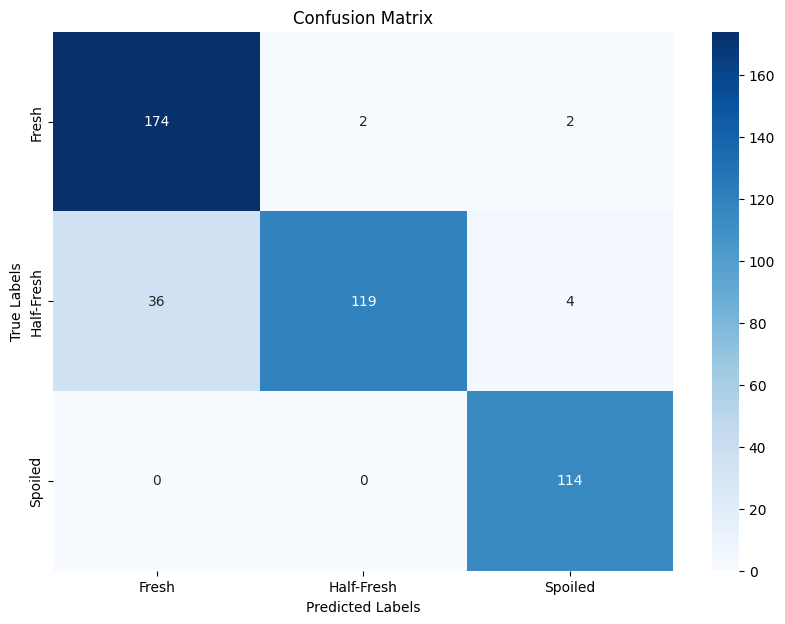

In [124]:
# Assuming the y_col has the class names as provided in your code ['Fresh', 'Half-Fresh', 'Spoiled']
class_labels = ['Fresh', 'Half-Fresh', 'Spoiled']

# Make predictions on the validation set
valid_predictions = model.predict(valid_generator)

# Convert predictions from one-hot encoding to class labels
valid_pred_classes = np.argmax(valid_predictions, axis=1)

# Extract true labels from the dataframe
true_labels = valid_data[['Fresh', 'Half-Fresh', 'Spoiled']].values
true_classes = np.argmax(true_labels, axis=1)

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_classes, valid_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

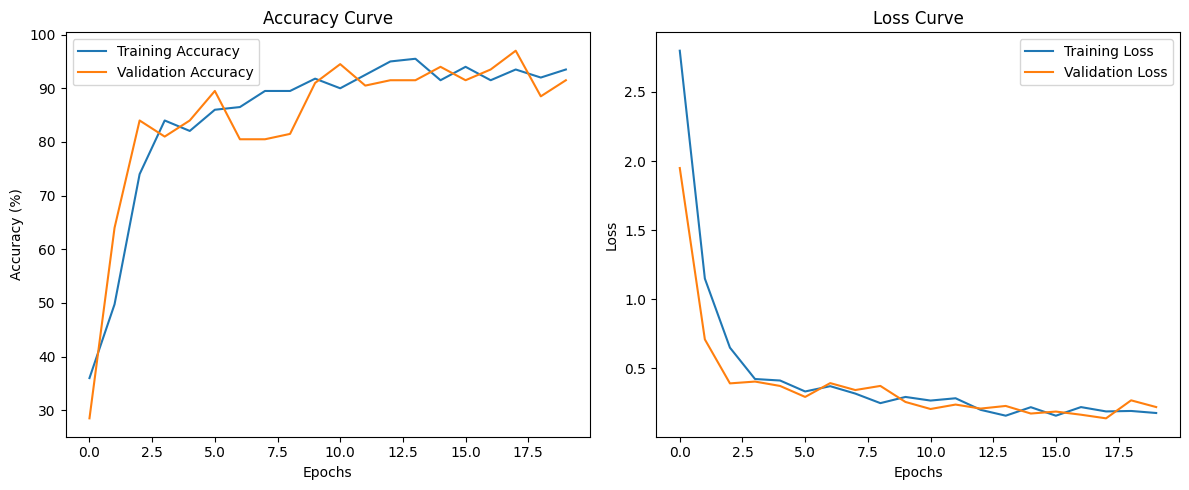

In [125]:
# Extract loss and accuracy for training and validation sets
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = [x * 100 for x in history.history['accuracy']]
val_acc = [x * 100 for x in history.history['val_accuracy']]

# Determine the number of epochs
epochs = range(len(train_loss))

# Plot the loss curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot the accuracy curves
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()

In [126]:
# Generate the classification report
report = classification_report(true_classes, valid_pred_classes, target_names=class_labels)

# Print the classification report
print(report)

              precision    recall  f1-score   support

       Fresh       0.83      0.98      0.90       178
  Half-Fresh       0.98      0.75      0.85       159
     Spoiled       0.95      1.00      0.97       114

    accuracy                           0.90       451
   macro avg       0.92      0.91      0.91       451
weighted avg       0.91      0.90      0.90       451



In [21]:
# Evaluate the model on the test data
loss, accuracy = model.evaluate(valid_generator)
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')

15/15 [==============================] - 1s 79ms/step - loss: 0.0997 - accuracy: 0.9756
Test loss: 0.09972751885652542
Test accuracy: 0.9756097793579102


# Train resNet50

In [14]:
from tensorflow.keras.applications import ResNet50

base_model_2 = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers on top of the ResNet50 base
x = base_model_2.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)

# Define the full model
model_2 = Model(inputs=base_model_2.input, outputs=predictions)

# Freeze the ResNet50 base model layers
for layer in base_model_2.layers:
    layer.trainable = False

# Compile the model
model_2.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
history = model_2.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=20,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // valid_generator.batch_size
)

Epoch 1/20
56/56 [==============================] - 25s 376ms/step - loss: 1.2780 - accuracy: 0.4498 - val_loss: 0.8452 - val_accuracy: 0.5692
Epoch 2/20
56/56 [==============================] - 21s 371ms/step - loss: 0.8554 - accuracy: 0.5754 - val_loss: 0.9393 - val_accuracy: 0.5268
Epoch 3/20
56/56 [==============================] - 21s 369ms/step - loss: 0.8493 - accuracy: 0.5648 - val_loss: 0.9137 - val_accuracy: 0.5045
Epoch 4/20
56/56 [==============================] - 21s 368ms/step - loss: 0.8102 - accuracy: 0.6007 - val_loss: 0.8639 - val_accuracy: 0.6362
Epoch 5/20
56/56 [==============================] - 21s 367ms/step - loss: 0.7388 - accuracy: 0.6523 - val_loss: 0.7347 - val_accuracy: 0.6451
Epoch 6/20
56/56 [==============================] - 20s 364ms/step - loss: 0.7680 - accuracy: 0.6360 - val_loss: 0.7831 - val_accuracy: 0.5960
Epoch 7/20
56/56 [==============================] - 20s 365ms/step - loss: 0.8129 - accuracy: 0.5855 - val_loss: 0.8329 - val_accuracy: 0.5513

In [16]:
# Evaluate the model on the test data
loss, accuracy = model_2.evaluate(valid_generator)
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')

15/15 [==============================] - 1s 60ms/step - loss: 0.6570 - accuracy: 0.7140
Test loss: 0.6569552421569824
Test accuracy: 0.7139689326286316


15/15 [==============================] - 2s 67ms/step


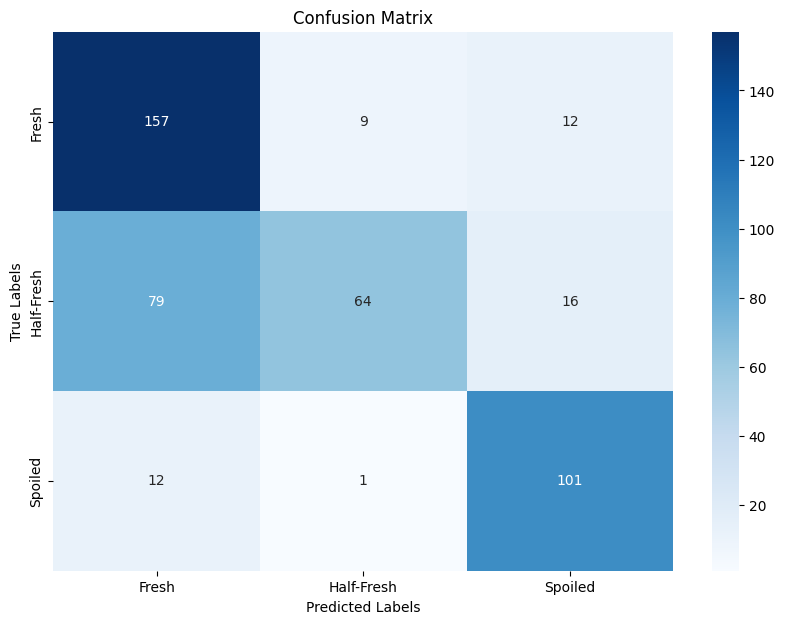

In [17]:
# Assuming the y_col has the class names as provided in your code ['Fresh', 'Half-Fresh', 'Spoiled']
class_labels = ['Fresh', 'Half-Fresh', 'Spoiled']

# Make predictions on the validation set
valid_predictions = model_2.predict(valid_generator)

# Convert predictions from one-hot encoding to class labels
valid_pred_classes = np.argmax(valid_predictions, axis=1)

# Extract true labels from the dataframe
true_labels = valid_data[['Fresh', 'Half-Fresh', 'Spoiled']].values
true_classes = np.argmax(true_labels, axis=1)

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_classes, valid_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

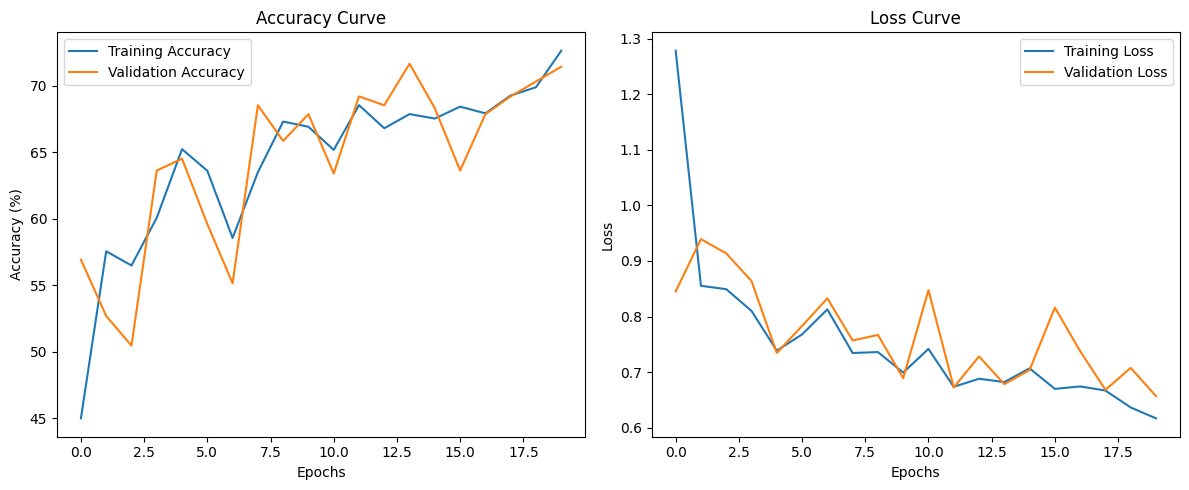

In [18]:
# Extract loss and accuracy for training and validation sets
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = [x * 100 for x in history.history['accuracy']]
val_acc = [x * 100 for x in history.history['val_accuracy']]

# Determine the number of epochs
epochs = range(len(train_loss))

# Plot the loss curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot the accuracy curves
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()

In [19]:
# Generate the classification report
report = classification_report(true_classes, valid_pred_classes, target_names=class_labels)

# Print the classification report
print(report)

              precision    recall  f1-score   support

       Fresh       0.63      0.88      0.74       178
  Half-Fresh       0.86      0.40      0.55       159
     Spoiled       0.78      0.89      0.83       114

    accuracy                           0.71       451
   macro avg       0.76      0.72      0.71       451
weighted avg       0.75      0.71      0.69       451



## ANN

In [9]:
model_3 = Sequential()
model_3.add(Flatten(input_shape=(224, 224, 3)))
model_3.add(Dense(512, activation='relu'))
model_3.add(Dropout(0.2))
model_3.add(Dense(512, activation='relu'))
model_3.add(Dropout(0.2))
model_3.add(Dense(3, activation='softmax'))
model_3.summary()

2024-06-18 02:40:49.883671: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x560ef4183420 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2024-06-18 02:40:49.883706: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2024-06-18 02:40:51.787394: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20007 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9
2024-06-18 02:40:51.792054: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x560f097573c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-06-18 02:40:51.792100: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA L4, Compute Capability 8.9


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 150528)            0         
                                                                 
 dense (Dense)               (None, 512)               77070848  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 77335043 (295.01 MB)
Trainable params: 773

In [10]:
model_3.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

history = model_3.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // valid_generator.batch_size,
    epochs=20
)

Epoch 1/20


2024-06-18 02:41:18.093038: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-06-18 02:41:18.201967: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-18 02:41:18.723793: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8900
2024-06-18 02:41:19.083706: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


56/56 [==============================] - 26s 373ms/step - loss: 3.6270 - accuracy: 0.3595 - val_loss: 1.0343 - val_accuracy: 0.4665
Epoch 2/20
56/56 [==============================] - 20s 353ms/step - loss: 1.0313 - accuracy: 0.4470 - val_loss: 0.9872 - val_accuracy: 0.4866
Epoch 3/20
56/56 [==============================] - 20s 359ms/step - loss: 1.0241 - accuracy: 0.4633 - val_loss: 1.0093 - val_accuracy: 0.4844
Epoch 4/20
56/56 [==============================] - 20s 356ms/step - loss: 0.9942 - accuracy: 0.4835 - val_loss: 0.9618 - val_accuracy: 0.5045
Epoch 5/20
56/56 [==============================] - 20s 355ms/step - loss: 1.0070 - accuracy: 0.4773 - val_loss: 1.0597 - val_accuracy: 0.4576
Epoch 6/20
56/56 [==============================] - 20s 365ms/step - loss: 1.0263 - accuracy: 0.4408 - val_loss: 1.0111 - val_accuracy: 0.4107
Epoch 7/20
56/56 [==============================] - 20s 349ms/step - loss: 1.0046 - accuracy: 0.4655 - val_loss: 1.0020 - val_accuracy: 0.4643
Epoch 8/20

15/15 [==============================] - 1s 64ms/step


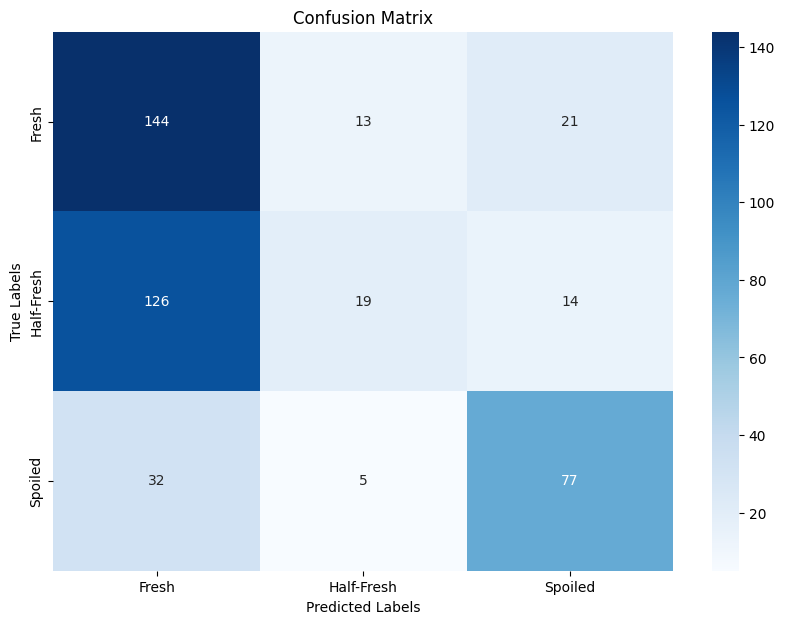

In [11]:
# Assuming the y_col has the class names as provided in your code ['Fresh', 'Half-Fresh', 'Spoiled']
class_labels = ['Fresh', 'Half-Fresh', 'Spoiled']

# Make predictions on the validation set
valid_predictions = model_3.predict(valid_generator)

# Convert predictions from one-hot encoding to class labels
valid_pred_classes = np.argmax(valid_predictions, axis=1)

# Extract true labels from the dataframe
true_labels = valid_data[['Fresh', 'Half-Fresh', 'Spoiled']].values
true_classes = np.argmax(true_labels, axis=1)

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_classes, valid_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

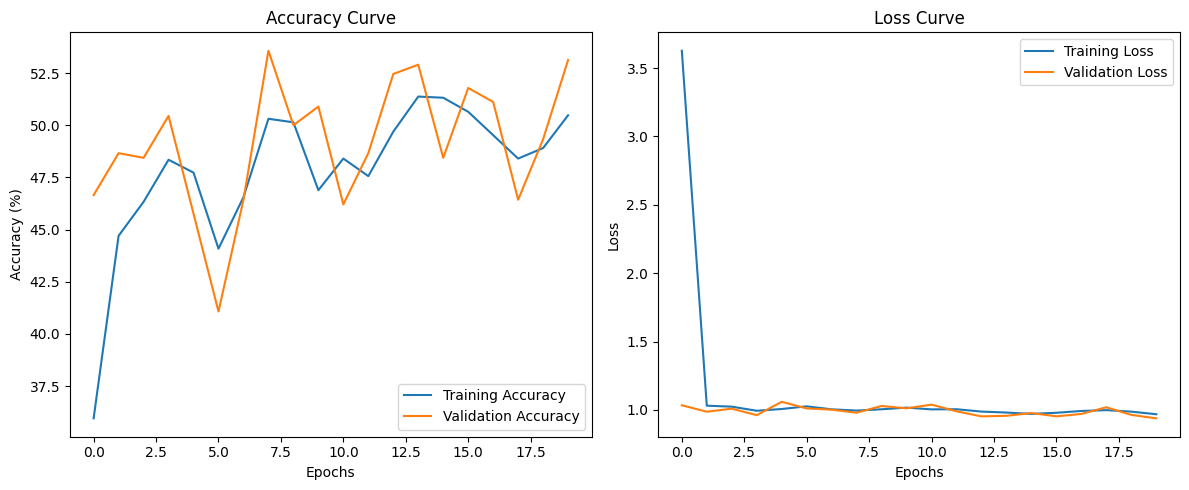

In [12]:
# Extract loss and accuracy for training and validation sets
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = [x * 100 for x in history.history['accuracy']]
val_acc = [x * 100 for x in history.history['val_accuracy']]

# Determine the number of epochs
epochs = range(len(train_loss))

# Plot the loss curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot the accuracy curves
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()

In [13]:
# Generate the classification report
report = classification_report(true_classes, valid_pred_classes, target_names=class_labels)

# Print the classification report
print(report)

              precision    recall  f1-score   support

       Fresh       0.48      0.81      0.60       178
  Half-Fresh       0.51      0.12      0.19       159
     Spoiled       0.69      0.68      0.68       114

    accuracy                           0.53       451
   macro avg       0.56      0.53      0.49       451
weighted avg       0.54      0.53      0.48       451



## CNN Model

In [31]:
model_5 = Sequential()
model_5.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(224, 224, 3)))
model_5.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model_5.add(MaxPooling2D(pool_size=(2, 2)))
model_5.add(Dropout(0.2))
model_5.add(Flatten())
model_5.add(Dense(128, activation='relu'))
model_5.add(Dropout(0.2))
model_5.add(Dense(3, activation='softmax'))
model_5.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 64)      18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 110, 110, 64)      0         
 D)                                                              
                                                                 
 dropout_4 (Dropout)         (None, 110, 110, 64)      0         
                                                                 
 flatten_5 (Flatten)         (None, 774400)            0         
                                                                 
 dense_15 (Dense)            (None, 128)               99123328  
                                                      

In [32]:
model_5.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

history = model_5.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // valid_generator.batch_size,
    epochs=20
)

Epoch 1/20


2024-06-17 13:56:59.808330: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/dropout_4/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


56/56 [==============================] - 25s 356ms/step - loss: 2.1094 - accuracy: 0.3472 - val_loss: 1.0976 - val_accuracy: 0.3527
Epoch 2/20
56/56 [==============================] - 20s 360ms/step - loss: 1.0932 - accuracy: 0.3657 - val_loss: 1.0908 - val_accuracy: 0.3951
Epoch 3/20
56/56 [==============================] - 21s 366ms/step - loss: 1.0851 - accuracy: 0.4135 - val_loss: 1.0739 - val_accuracy: 0.4576
Epoch 4/20
56/56 [==============================] - 20s 363ms/step - loss: 1.0756 - accuracy: 0.4363 - val_loss: 1.0772 - val_accuracy: 0.5246
Epoch 5/20
56/56 [==============================] - 20s 361ms/step - loss: 1.0559 - accuracy: 0.4683 - val_loss: 1.0400 - val_accuracy: 0.4888
Epoch 6/20
56/56 [==============================] - 21s 367ms/step - loss: 1.0383 - accuracy: 0.4930 - val_loss: 1.0273 - val_accuracy: 0.5469
Epoch 7/20
56/56 [==============================] - 20s 359ms/step - loss: 1.0256 - accuracy: 0.5036 - val_loss: 1.0101 - val_accuracy: 0.5402
Epoch 8/20

15/15 [==============================] - 1s 59ms/step


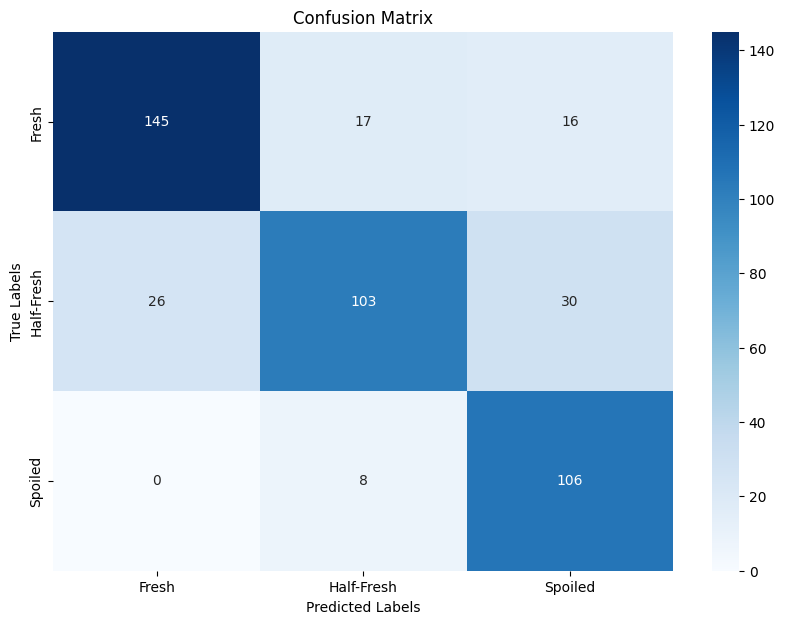

In [33]:
# Assuming the y_col has the class names as provided in your code ['Fresh', 'Half-Fresh', 'Spoiled']
class_labels = ['Fresh', 'Half-Fresh', 'Spoiled']

# Make predictions on the validation set
valid_predictions = model_5.predict(valid_generator)

# Convert predictions from one-hot encoding to class labels
valid_pred_classes = np.argmax(valid_predictions, axis=1)

# Extract true labels from the dataframe
true_labels = valid_data[['Fresh', 'Half-Fresh', 'Spoiled']].values
true_classes = np.argmax(true_labels, axis=1)

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_classes, valid_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

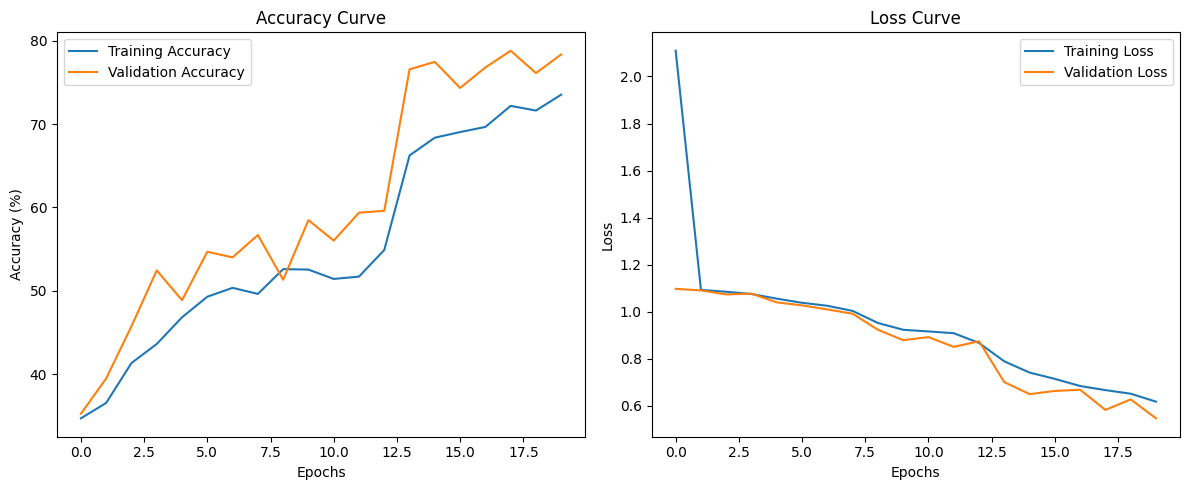

In [34]:
# Extract loss and accuracy for training and validation sets
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = [x * 100 for x in history.history['accuracy']]
val_acc = [x * 100 for x in history.history['val_accuracy']]

# Determine the number of epochs
epochs = range(len(train_loss))

# Plot the loss curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot the accuracy curves
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()

In [35]:
# Generate the classification report
report = classification_report(true_classes, valid_pred_classes, target_names=class_labels)

# Print the classification report
print(report)

              precision    recall  f1-score   support

       Fresh       0.85      0.81      0.83       178
  Half-Fresh       0.80      0.65      0.72       159
     Spoiled       0.70      0.93      0.80       114

    accuracy                           0.78       451
   macro avg       0.78      0.80      0.78       451
weighted avg       0.79      0.78      0.78       451



## CNN Model (Tuned Parameter)

In [56]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from keras.regularizers import l2

In [113]:
model_6 = Sequential()

# Add layers with the kernel regularizer
model_6.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(224, 224, 3), padding='same'))
model_6.add(MaxPooling2D(pool_size=(2, 2)))
model_6.add(Dropout(0.2))
model_6.add(Conv2D(96, kernel_size=(3, 3), activation='relu', padding='same'))
model_6.add(MaxPooling2D(pool_size=(2, 2)))
model_6.add(Dropout(0.2))
model_6.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
model_6.add(MaxPooling2D(pool_size=(2, 2)))
model_6.add(Dropout(0.2))
model_6.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
model_6.add(MaxPooling2D(pool_size=(2, 2)))
model_6.add(Dropout(0.2))
model_6.add(Flatten())
model_6.add(Dense(512, activation='relu'))
model_6.add(Dropout(0.2))
model_6.add(Dense(3, activation='softmax'))

# Display the model summary
model_6.summary()

Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_79 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 max_pooling2d_53 (MaxPooli  (None, 112, 112, 64)      0         
 ng2D)                                                           
                                                                 
 dropout_75 (Dropout)        (None, 112, 112, 64)      0         
                                                                 
 conv2d_80 (Conv2D)          (None, 112, 112, 96)      55392     
                                                                 
 max_pooling2d_54 (MaxPooli  (None, 56, 56, 96)        0         
 ng2D)                                                           
                                                                 
 dropout_76 (Dropout)        (None, 56, 56, 96)      

In [114]:
model_6.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

history = model_6.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // valid_generator.batch_size,
    epochs=20
)

Epoch 1/20


2024-06-17 16:06:58.297607: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_39/dropout_75/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


56/56 [==============================] - 24s 366ms/step - loss: 1.0525 - accuracy: 0.4352 - val_loss: 1.0381 - val_accuracy: 0.5513
Epoch 2/20
56/56 [==============================] - 20s 363ms/step - loss: 0.9268 - accuracy: 0.5446 - val_loss: 1.0078 - val_accuracy: 0.4353
Epoch 3/20
56/56 [==============================] - 21s 365ms/step - loss: 0.8220 - accuracy: 0.6147 - val_loss: 0.9308 - val_accuracy: 0.5848
Epoch 4/20
56/56 [==============================] - 21s 366ms/step - loss: 0.7368 - accuracy: 0.6506 - val_loss: 0.8529 - val_accuracy: 0.6629
Epoch 5/20
56/56 [==============================] - 21s 365ms/step - loss: 0.6643 - accuracy: 0.6994 - val_loss: 0.7666 - val_accuracy: 0.6875
Epoch 6/20
56/56 [==============================] - 21s 370ms/step - loss: 0.5762 - accuracy: 0.7515 - val_loss: 0.7500 - val_accuracy: 0.6741
Epoch 7/20
56/56 [==============================] - 20s 365ms/step - loss: 0.4780 - accuracy: 0.7897 - val_loss: 0.6899 - val_accuracy: 0.7277
Epoch 8/20

15/15 [==============================] - 1s 60ms/step


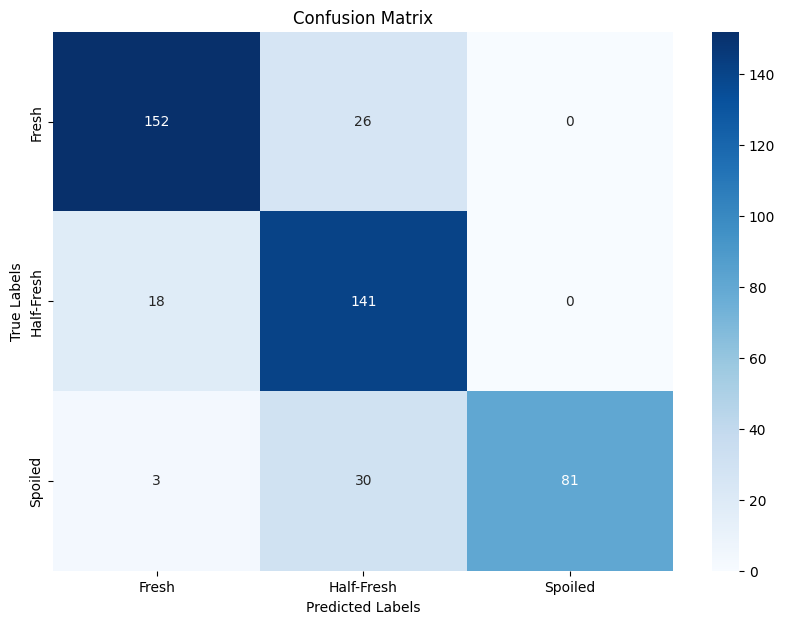

In [115]:
# Assuming the y_col has the class names as provided in your code ['Fresh', 'Half-Fresh', 'Spoiled']
class_labels = ['Fresh', 'Half-Fresh', 'Spoiled']

# Make predictions on the validation set
valid_predictions = model_6.predict(valid_generator)

# Convert predictions from one-hot encoding to class labels
valid_pred_classes = np.argmax(valid_predictions, axis=1)

# Extract true labels from the dataframe
true_labels = valid_data[['Fresh', 'Half-Fresh', 'Spoiled']].values
true_classes = np.argmax(true_labels, axis=1)

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_classes, valid_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

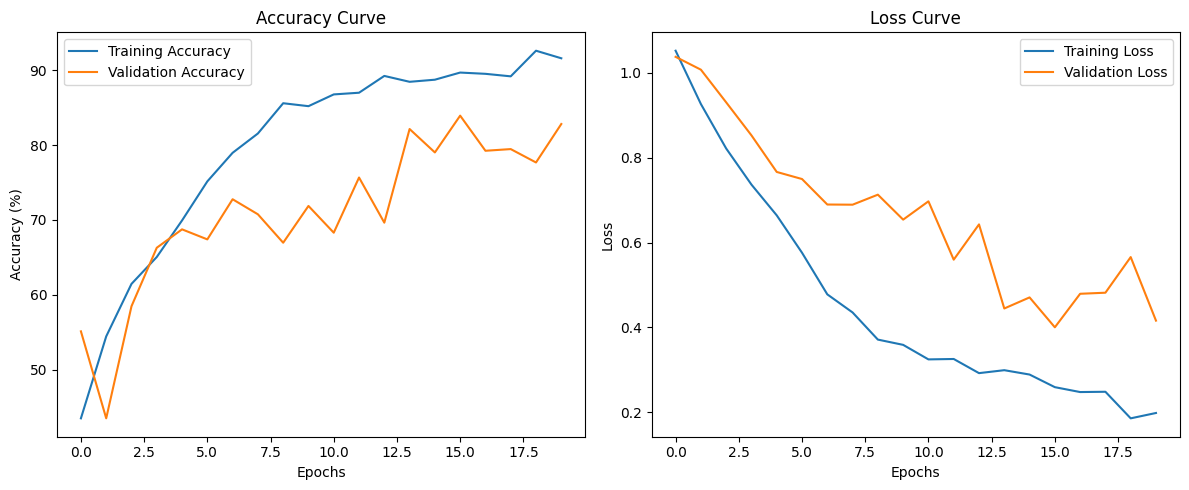

In [116]:
# Extract loss and accuracy for training and validation sets
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = [x * 100 for x in history.history['accuracy']]
val_acc = [x * 100 for x in history.history['val_accuracy']]

# Determine the number of epochs
epochs = range(len(train_loss))

# Plot the loss curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot the accuracy curves
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()

In [117]:
# Generate the classification report
report = classification_report(true_classes, valid_pred_classes, target_names=class_labels)

# Print the classification report
print(report)

              precision    recall  f1-score   support

       Fresh       0.88      0.85      0.87       178
  Half-Fresh       0.72      0.89      0.79       159
     Spoiled       1.00      0.71      0.83       114

    accuracy                           0.83       451
   macro avg       0.86      0.82      0.83       451
weighted avg       0.85      0.83      0.83       451



# Yilin Code

# Vgg Tuning

In [78]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import pandas as pd

In [54]:
# Ensure the columns are correct
print("Train Data Columns:")
print(train_data.columns)

print("Sample Train Data:")
print(train_data.head())

print("Valid Data Columns:")
print(valid_data.columns)

print("Sample Valid Data:")
print(valid_data.head())

Train Data Columns:
Index(['filename', 'Fresh', 'Half-Fresh', 'Spoiled'], dtype='object')
Sample Train Data:
                                            filename  Fresh  Half-Fresh  \
0  sam/Meat Freshness.v1-new-dataset.multiclass/t...      0           0   
1  sam/Meat Freshness.v1-new-dataset.multiclass/t...      0           0   
2  sam/Meat Freshness.v1-new-dataset.multiclass/t...      1           0   
3  sam/Meat Freshness.v1-new-dataset.multiclass/t...      1           0   
4  sam/Meat Freshness.v1-new-dataset.multiclass/t...      1           0   

   Spoiled  
0        1  
1        1  
2        0  
3        0  
4        0  
Valid Data Columns:
Index(['filename', 'Fresh', 'Half-Fresh', 'Spoiled'], dtype='object')
Sample Valid Data:
                                            filename  Fresh  Half-Fresh  \
0  sam/Meat Freshness.v1-new-dataset.multiclass/v...      0           1   
1  sam/Meat Freshness.v1-new-dataset.multiclass/v...      1           0   
2  sam/Meat Freshness.v1-new

In [79]:
# Compute class weights
def compute_class_weights(dataframe, label_columns):
    labels = dataframe[label_columns].values
    labels = np.argmax(labels, axis=1)
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(labels),
        y=labels
    )
    return dict(enumerate(class_weights))

class_weights_dict = compute_class_weights(train_data, ['Fresh', 'Half-Fresh', 'Spoiled'])

# Print class weights for debugging
print("Class Weights:", class_weights_dict)

Class Weights: {0: 0.8962962962962963, 1: 0.9603174603174603, 2: 1.1862745098039216}


In [80]:
# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(rescale=1./255)

# Load and preprocess the training images
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_data,
    x_col='filename',
    y_col=['Fresh', 'Half-Fresh', 'Spoiled'],
    target_size=(224, 224),
    batch_size=50,
    class_mode='raw'
)

# Load and preprocess the validation images
valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=valid_data,
    x_col='filename',
    y_col=['Fresh', 'Half-Fresh', 'Spoiled'],
    target_size=(224, 224),
    batch_size=50,
    class_mode='raw',
    shuffle=False
)

# train_generator = train_datagen.flow_from_dataframe(
#     dataframe=train_data,
#     x_col='filename',
#     y_col=['Fresh', 'Half-Fresh', 'Spoiled'],
#     target_size=(224, 224),
#     batch_size=32,
#     class_mode='raw',
#     shuffle=False
# )

# valid_generator = valid_datagen.flow_from_dataframe(
#     dataframe=valid_data,
#     x_col='filename',
#     y_col=['Fresh', 'Half-Fresh', 'Spoiled'],
#     target_size=(224, 224),
#     batch_size=32,
#     class_mode='raw',
#     shuffle=False
# )

Found 1815 validated image filenames.
Found 451 validated image filenames.


In [81]:
# Learning rate scheduler function
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * np.exp(-0.1)

In [82]:
# Get the number of classes
num_classes = len(['Fresh', 'Half-Fresh', 'Spoiled'])

# Load the VGG16 model with pre-trained weights
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers on top of the VGG base
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)  # Add dropout to reduce overfitting
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)  # Add dropout to reduce overfitting
predictions = Dense(num_classes, activation='softmax')(x)

# Define the full model
model_vgg = Model(inputs=base_model.input, outputs=predictions)

# Unfreeze more layers of the base model for fine-tuning
for layer in base_model.layers[-8:]:
    layer.trainable = True

# Compile the model with class weights
model_vgg.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Define early stopping and learning rate reduction on plateau callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

# Train the model with class weights
history = model_vgg.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=30,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // valid_generator.batch_size,
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weights_dict  # Use the class weights here
)

# Save the model
model_vgg.save('meat_classification_model_with_class_weights.h5')

# Predict the labels for the validation set
predictions = model_vgg.predict(valid_generator, steps=valid_generator.samples // valid_generator.batch_size + 1)
predicted_classes = np.argmax(predictions, axis=1)


Epoch 1/30
36/36 [==============================] - 29s 644ms/step - loss: 1.3250 - accuracy: 0.5207 - val_loss: 5.0487 - val_accuracy: 0.5045 - lr: 1.0000e-04
Epoch 2/30
36/36 [==============================] - 27s 751ms/step - loss: 0.8563 - accuracy: 0.6958 - val_loss: 4.4167 - val_accuracy: 0.6473 - lr: 1.0000e-04
Epoch 3/30
36/36 [==============================] - 26s 727ms/step - loss: 0.6362 - accuracy: 0.7433 - val_loss: 17.2180 - val_accuracy: 0.3951 - lr: 1.0000e-04
Epoch 4/30
36/36 [==============================] - 27s 733ms/step - loss: 0.6225 - accuracy: 0.7575 - val_loss: 6.1352 - val_accuracy: 0.4799 - lr: 1.0000e-04
Epoch 5/30
36/36 [==============================] - 26s 722ms/step - loss: 0.5394 - accuracy: 0.7819 - val_loss: 6.9283 - val_accuracy: 0.5781 - lr: 1.0000e-04
Epoch 6/30
36/36 [==============================] - 27s 737ms/step - loss: 0.3993 - accuracy: 0.8289 - val_loss: 0.3962 - val_accuracy: 0.8237 - lr: 1.0000e-04
Epoch 7/30
36/36 [=====================

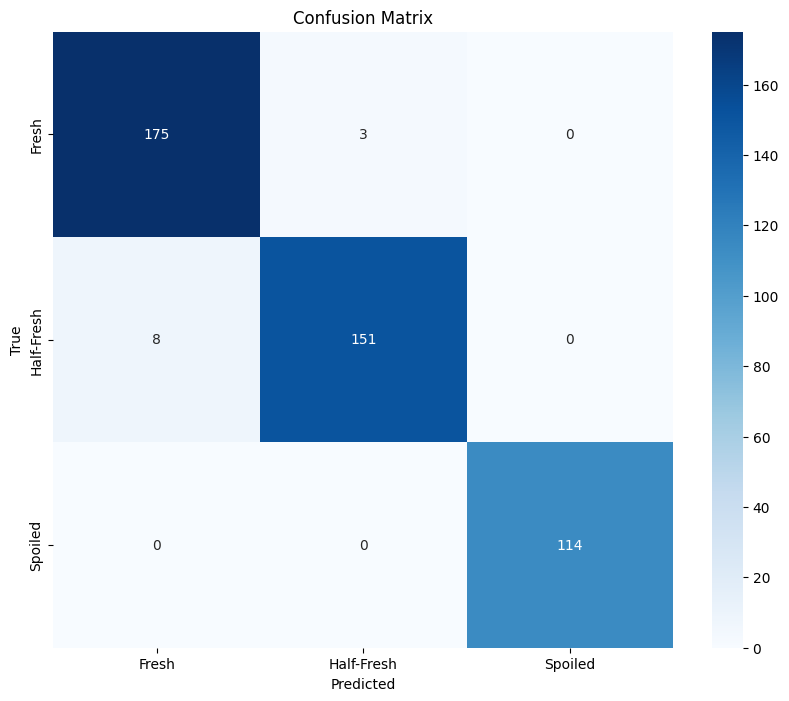

Classification Report
              precision    recall  f1-score   support

       Fresh       0.96      0.98      0.97       178
  Half-Fresh       0.98      0.95      0.96       159
     Spoiled       1.00      1.00      1.00       114

    accuracy                           0.98       451
   macro avg       0.98      0.98      0.98       451
weighted avg       0.98      0.98      0.98       451



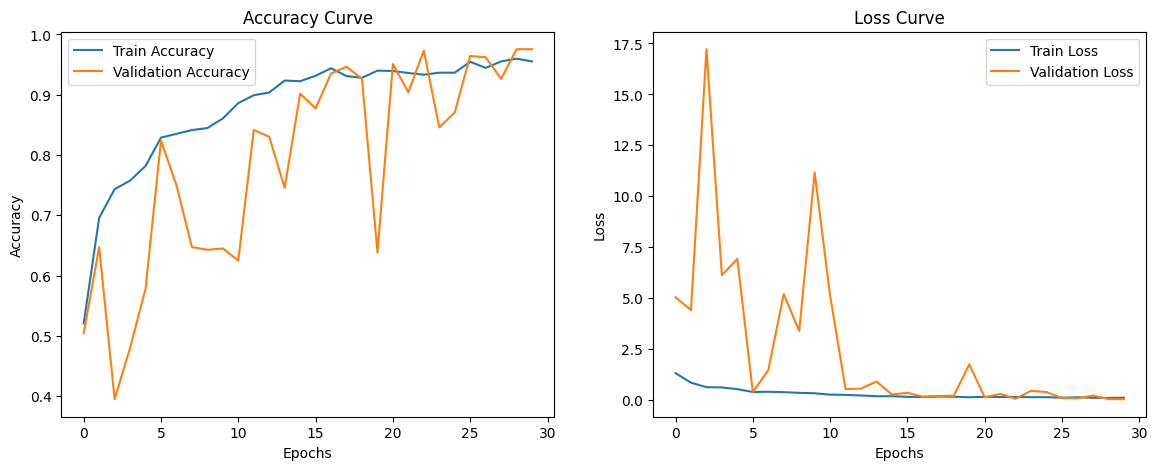

In [84]:
# Function to plot accuracy and loss curves
def plot_accuracy_and_loss(history):
    # Accuracy plot
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curve')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()

    plt.show()

# Get the number of classes
num_classes = len(['Fresh', 'Half-Fresh', 'Spoiled'])

# Extract true labels from the validation generator
true_labels = []
for i in range(len(valid_generator)):
    x, y = valid_generator.next()
    true_labels.extend(np.argmax(y, axis=1))
true_labels = np.array(true_labels)

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Fresh', 'Half-Fresh', 'Spoiled'], yticklabels=['Fresh', 'Half-Fresh', 'Spoiled'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print('Classification Report')
print(classification_report(true_labels, predicted_classes, target_names=['Fresh', 'Half-Fresh', 'Spoiled']))

# Plot accuracy and loss curves
plot_accuracy_and_loss(history)

In [ ]:
# Extract loss and accuracy for training and validation sets
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = [x * 100 for x in history.history['accuracy']]
val_acc = [x * 100 for x in history.history['val_accuracy']]

# Determine the number of epochs
epochs = range(len(train_loss))

# Plot the loss curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot the accuracy curves
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()

## Augmentation image show

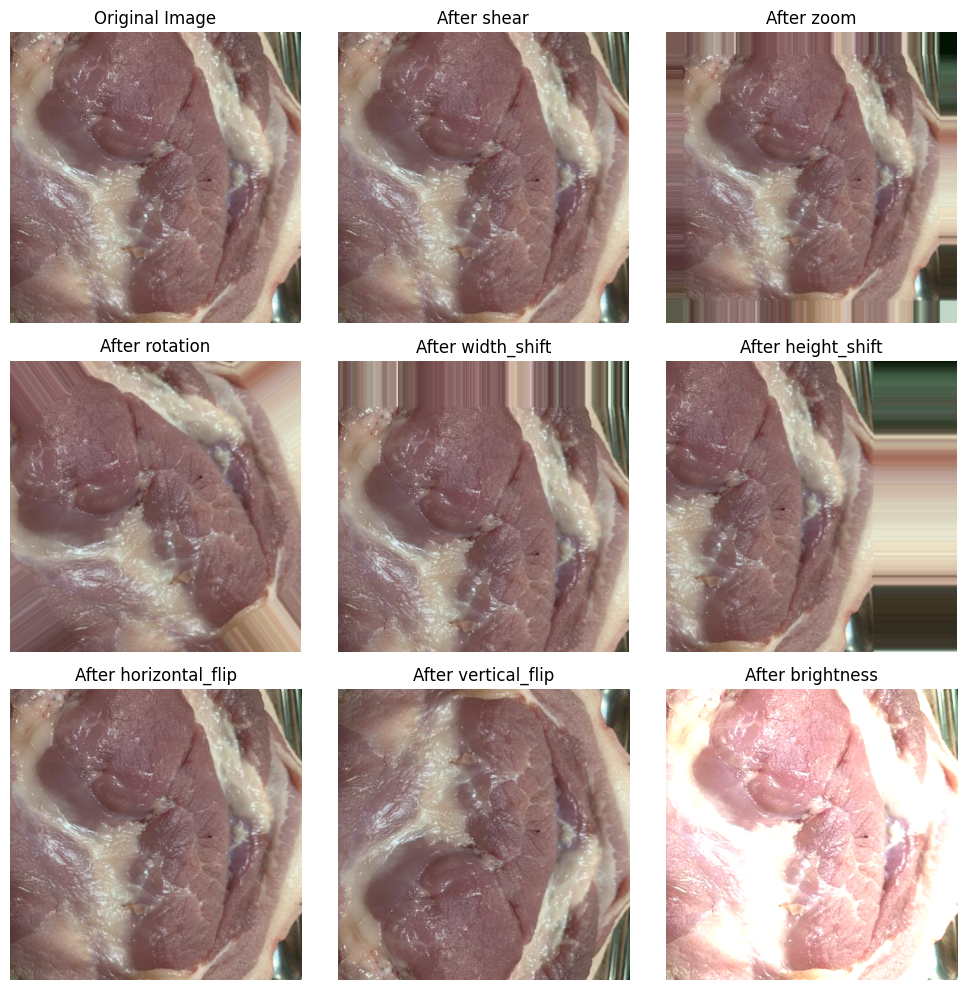

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

# Load an example image
img_path = 'sam/Meat Freshness.v1-new-dataset.multiclass/train/HALF-FRESH-22-_JPG.rf.124fd715f9438d804379ed3e49a1a23d.jpg'  # Replace with the path to an example image
img = load_img(img_path)
x = img_to_array(img)
x = np.expand_dims(x, axis=0)

# Original image
plt.figure(figsize=(10, 10))
plt.subplot(3, 3, 1)
plt.imshow(img)
plt.title("Original Image")
plt.axis('off')

# Define the augmentation parameters
augmentation_parameters = {
    'shear': ImageDataGenerator(shear_range=0.2),
    'zoom': ImageDataGenerator(zoom_range=0.2),
    'rotation': ImageDataGenerator(rotation_range=40),
    'width_shift': ImageDataGenerator(width_shift_range=0.3),
    'height_shift': ImageDataGenerator(height_shift_range=0.3),
    'horizontal_flip': ImageDataGenerator(horizontal_flip=True),
    'vertical_flip': ImageDataGenerator(vertical_flip=True),
    'brightness': ImageDataGenerator(brightness_range=[1.5, 2])
}

# Apply and plot each augmentation
for i, (key, datagen) in enumerate(augmentation_parameters.items(), start=2):
    augmented_img = datagen.flow(x, batch_size=1).next()[0].astype('uint8')
    plt.subplot(3, 3, i)
    plt.imshow(augmented_img)
    plt.title(f"After {key}")
    plt.axis('off')

plt.tight_layout()
plt.show()
